In [1]:
import pandas as pd
import numpy as np
import wfdb
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import pickle

import sys
sys.path.insert(0,"/Users/tgermain/Documents/code/Persistent Pattern Discovery/src")
from plotting import get_relative_lag,get_barycenter

# MITDB 800 Mostif Discovery Dataset Creation

In [2]:
def filter_list(files): #Function to recover all patient present in the dataset
    patients= []
    for file in files: 
        if "atr" in file: 
            name = file.split(".")[0]
            if len(name)>0:
                patients.append(name)

    patients = np.unique(patients)

    return patients

In [3]:
folder_path = "/Volumes/Ultra Touch/Data/physionet/mitdb_800"
files = filter_list(os.listdir(folder_path))

## Label Analysis

For more information about labels refer to: https://archive.physionet.org/physiobank/annotations.shtml#noise



Labels: ['N','S','V'] represent 91.0% of the heartbeat occurrences


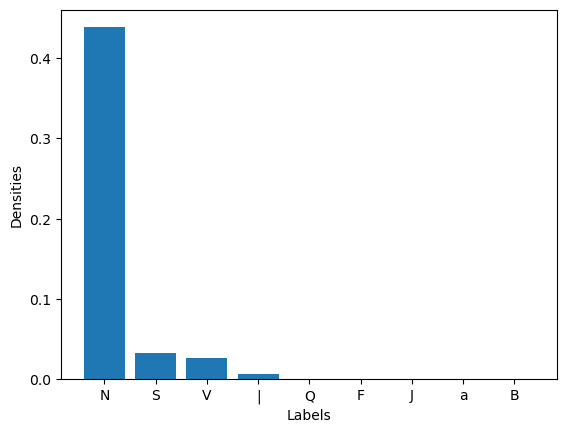

In [4]:
symbs = []
counts = []
for file in files: 
    annotation = wfdb.rdann(folder_path+"/"+file,extension="atr")
    symbs.append(annotation.symbol)
symbs,counts = np.unique(np.concatenate(symbs), return_counts=True)

beat_labels= np.array(['/', '?', 'A', 'B', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V','a', 'e', 'f', 'j', 'n', 'r'])
sorter = np.argsort(symbs)
beat_label_idx = sorter[np.searchsorted(symbs, beat_labels,sorter = sorter)]
beat_label_counts = counts[beat_label_idx]
densities = beat_label_counts/beat_label_counts.sum()
sort_idx = np.argsort(densities)[::-1]
plt.bar(symbs[beat_label_idx][sort_idx],densities[sort_idx])
plt.xlabel("Labels")
plt.ylabel("Densities")

print(f"Labels: ['N','S','V'] represent {np.round(densities[sort_idx][:3].sum(),2)*100}% of the heartbeat occurrences")

**Beat annotations:**
- **N** : Normal beat (displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)
- **L** : Left bundle branch block beat
- **R** : Right bundle branch block beat
- **B** : Bundle branch block beat (unspecified)
- **A** : Atrial premature beat
- **a** : Aberrated atrial premature beat
- **J** : Nodal (junctional) premature beat
- **S** : Supraventricular premature or ectopic beat (atrial or nodal)
- **V** : Premature ventricular contraction
- **r** : R-on-T premature ventricular contraction
- **F** : Fusion of ventricular and normal beat
- **e** : Atrial escape beat
- **j** : Nodal (junctional) escape beat
- **n** : Supraventricular escape beat (atrial or nodal)
- **E** : Ventricular escape beat
- **/** : Paced beat
- **f** : Fusion of paced and normal beat
- **Q** : Unclassifiable beat
- **?** : Beat not classified during learning

In [5]:
WINDOW_LENGTH = 100000
DATASET_PATH = "/Users/tgermain/Documents/code/Persistent Pattern Discovery/dataset/mitdb800/dataset.pkl"
LABEL_PATH = "/Users/tgermain/Documents/code/Persistent Pattern Discovery/dataset/mitdb800/labels.pkl"

> **Decision:** 
- For each ECG, we take the first dimention out the the two dimentions. 

In [6]:
lencoder = LabelEncoder().fit(beat_labels)
X = []
Y = []
dct_examples = {label: [] for label in beat_labels}
duration = []
for file in files: 
    record = wfdb.rdrecord(folder_path+"/"+ file)
    annotation = wfdb.rdann(folder_path+"/" + file,extension="atr")

    #prepare labels
    label_lst = []
    label_mask = np.array([True if lbl in beat_labels else False for lbl in annotation.symbol])
    t_labels = lencoder.transform(np.array(annotation.symbol)[label_mask])
    anns = (annotation.sample[:-1] + annotation.sample[1:])/2
    starts = anns[:-1].astype(int)
    ends = anns[1:].astype(int)-1
    duration.append(ends-starts)
    length = record.p_signal.shape[0]
    mask = np.zeros((len(beat_labels),length))
    label_mask = label_mask[1:-1]

    for s,e,l in zip(starts[label_mask],ends[label_mask],t_labels[:-2]): 
        mask[l,s:e] =1

    signal = record.p_signal[:,0]

    for i in range(signal.shape[0]//WINDOW_LENGTH): 
        X.append(signal[i*WINDOW_LENGTH:(i+1)*WINDOW_LENGTH])
        Y.append(mask[:,i*WINDOW_LENGTH:(i+1)*WINDOW_LENGTH])

    # Representent for each class: 
    for cls in beat_labels: 
        idxs = np.where(np.array(annotation.symbol)[1:-1][label_mask] == cls)[0]
        idxs = idxs[:min(10,len(idxs))]
        for s,e in zip(starts[label_mask][idxs],ends[label_mask][idxs]): 
            dct_examples[cls].append(signal[s:e])

In [7]:
#save dataset and labels
with open(DATASET_PATH, "wb") as f: 
    pickle.dump(X,f)
with open(LABEL_PATH, "wb") as f: 
    pickle.dump(Y,f)

### Example of ECG Time-Series

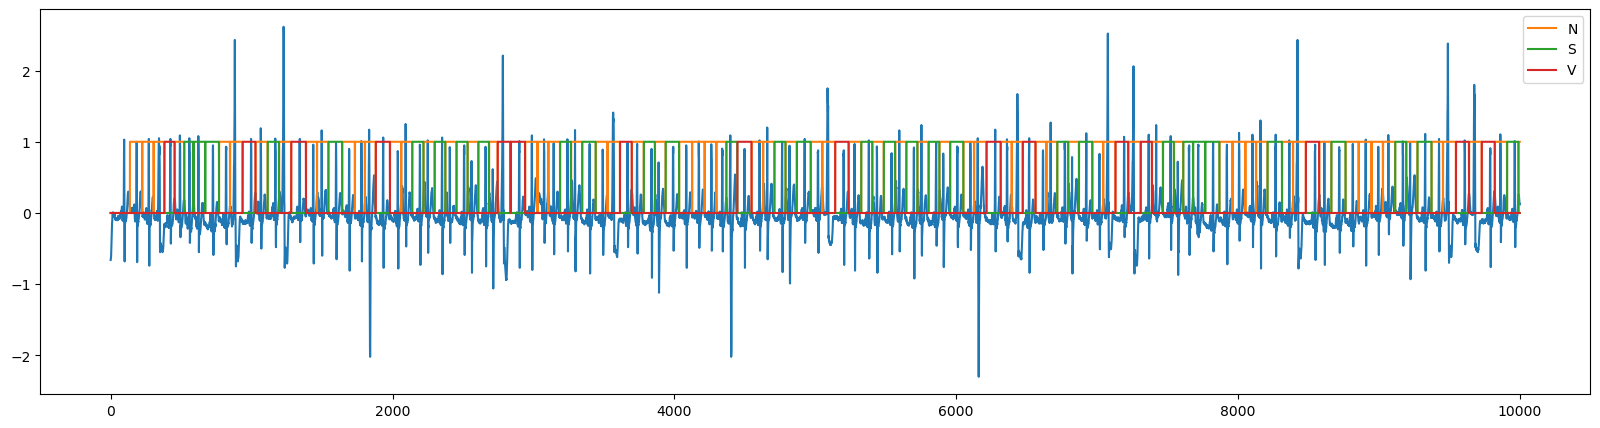

In [8]:
plt.figure(figsize=(20,5))
idx = 150
plt.plot(X[idx][:10000])
for cls,y in zip(beat_labels,Y[idx][:,:10000]): 
    if y.sum()>0:
        plt.plot(y,label=cls)
plt.legend()

### Illustrations of all label classes

/Users/tgermain/miniforge3/envs/perspa/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tgermain/miniforge3/envs/perspa/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tgermain/Documents/code/Persistent Pattern Discovery/src/plotting.py:15: RuntimeWarning: invalid value encountered in sqrt
  std1 = np.sqrt((np.convolve(np.ones(m),s1[::-1]**2)-avg_coeff*mean1**2)/avg_coeff)
/Users/tgermain/Documents/code/Persistent Pattern Discovery/src/plotting.py:14: RuntimeWarning: invalid value encountered in sqrt
  std0 = np.sqrt((np.convolve(s0**2,np.ones(n))-avg_coeff*mean0**2)/avg_coeff)


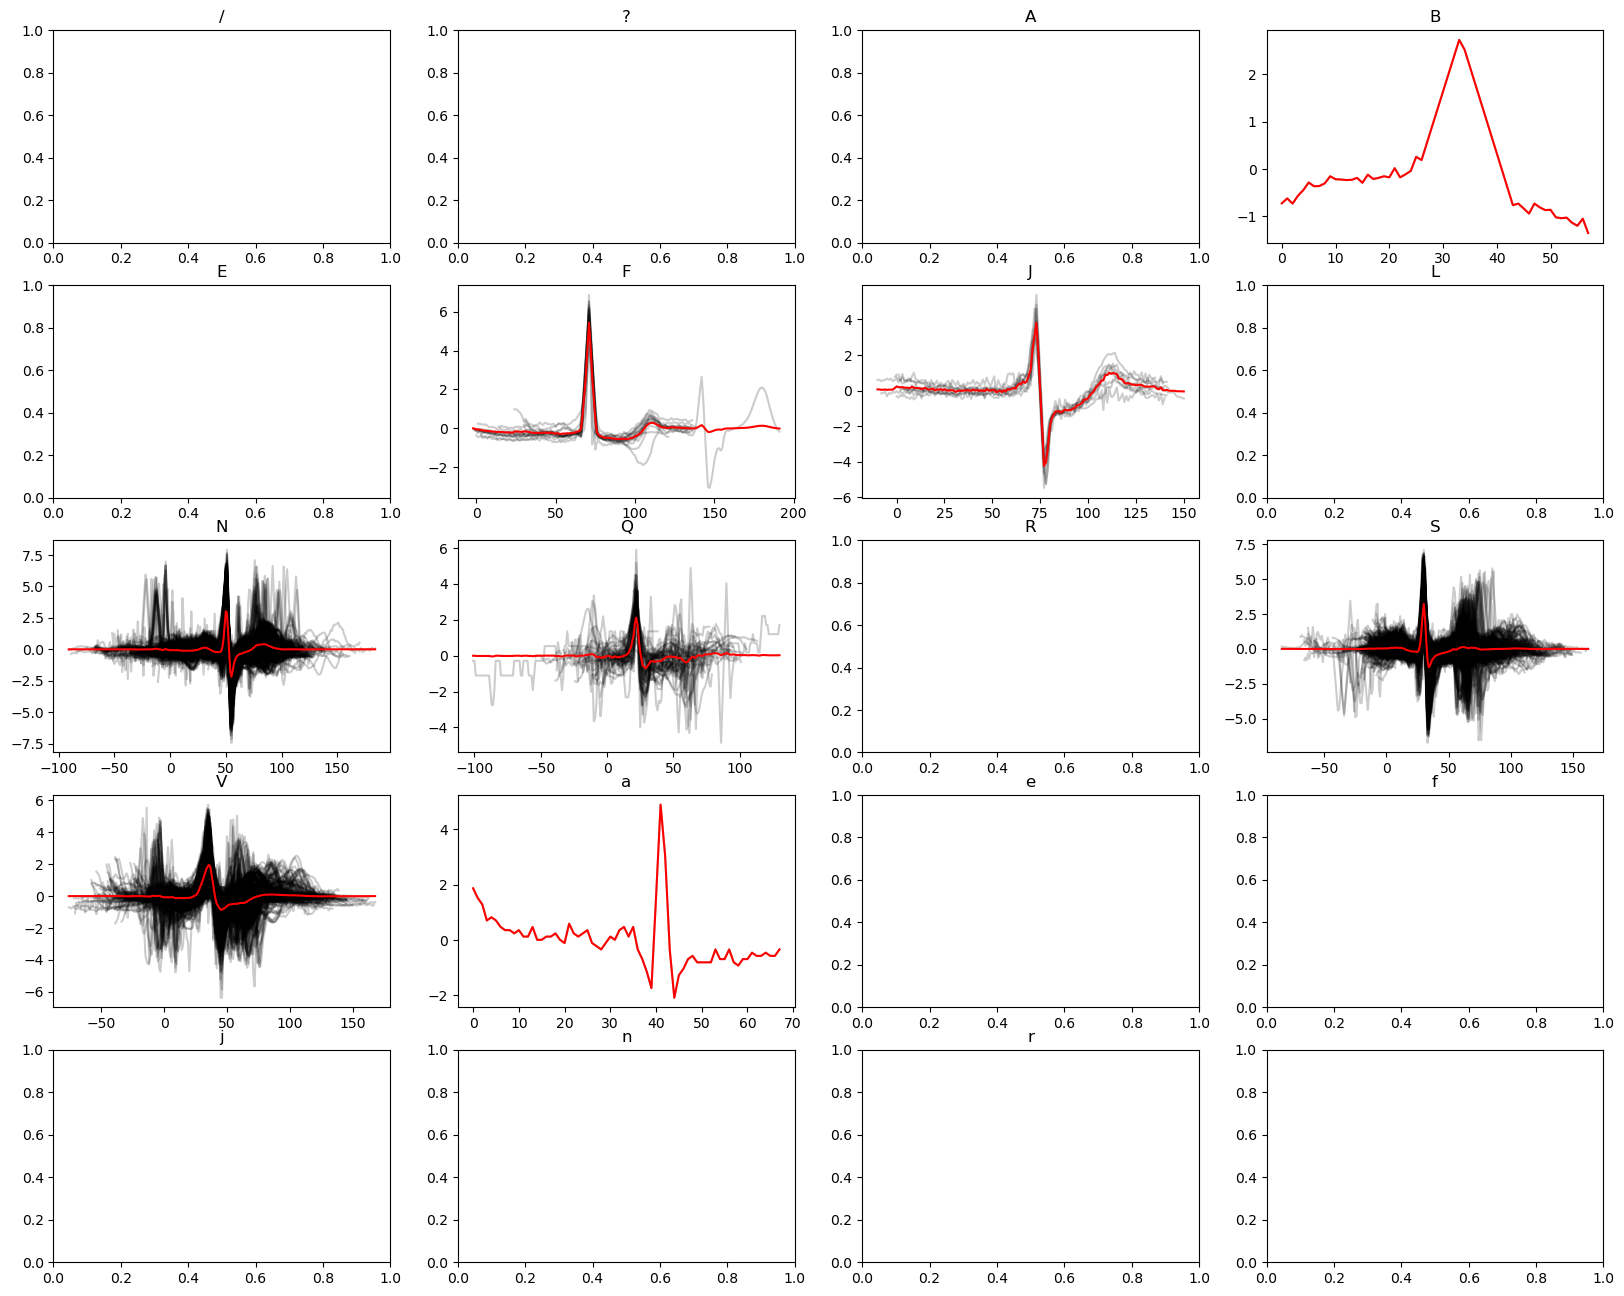

In [9]:
fig,axs = plt.subplots(len(beat_labels)//4+1,4,figsize=((len(beat_labels)//4+1)*4,16))

for cls,ax in zip(beat_labels,axs.flatten()):
    ax.set_title(cls)
    try:
        ds = [(l-l.mean())/l.std() for l in dct_examples[cls]]
        lags = get_relative_lag(ds)
        xbar,bar = get_barycenter(ds,lags)
        for j,ts in enumerate(ds): 
            x = np.arange(lags[j],lags[j]+ len(ts))
            ax.plot(x,ts,color="black",alpha=0.2)
        ax.plot(xbar,bar,color = "red")
    except: 
        pass

In [10]:
print(f"Average heartbeat length: {np.concatenate(duration).mean().astype(int)}")

Average heartbeat length: 94
